In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from GenZ import chunked_moddeling
from GenZ import get_model_df, System, get_summary_table, simplify_df, get_configs, ParallelismConfig, get_runtime_breakdown
from GenZ.Models.get_language_model import create_full_chunked_model, create_full_decode_model
from GenZ.Models.attention import mha_flash_attention_chunked
from GenZ.utils.plot_rooflines import display_df
import os
import pandas as pd


In [3]:
get_configs('meta-llama/meta-llama-3.1-405b')

In [4]:
import ipywidgets as widgets
from ipywidgets import interact

# def interactive_chunked_model_runtime(input_tokens, output_tokens, output_batch):
input_tokens = 1024
output_tokens = 1024
TP = 4
chunk_size = 512
system = System(frequency=1000 , flops=4500, off_chip_mem_size=(192*1024), compute_efficiency=1, memory_efficiency=1,
                offchip_mem_bw=8000, bits='int8', external_mem_bw=128, interchip_link_bw=900, interchip_link_latency=0.25, num_nodes=4)
runtime_plot_df = pd.DataFrame(columns=['Batching Type', 'Layer Name', 'Runtime', 'Chunk Size', 'Decode Batch'])
for chunk_size in [512,  2048]:
    for output_batch in [1, 16, 64]:
        # model = create_full_decode_model(name='gpt-3', input_sequence_length = output_tokens, tensor_parallel=TP)
        # model_df = get_model_df(model, system, batch_size=output_batch,  model_characterstics = False)
        # summary_table = get_summary_table(model_df, model_characterstics = False)
        # runtime_df = get_runtime_breakdown(model_df)
        # # display(model_df)
        # # display(summary_table)
        # df = pd.DataFrame(
        #     [   ['Continous', 'Embedding',   runtime_df.Embedding, chunk_size, output_batch],
        #         ['Continous', 'Collective',  runtime_df.Collective, chunk_size, output_batch],
        #         ['Continous', 'LA_layers',   runtime_df.LA_layers, chunk_size, output_batch],
        #         ['Continous', 'QKVO_layers', runtime_df.QKVO_layers, chunk_size, output_batch],
        #         ['Continous', 'FFN_layers',  runtime_df.FFN_layers, chunk_size, output_batch]],
        #     columns=['Batching Type', 'Layer Name', 'Runtime','Chunk Size', 'Decode Batch'])
        # runtime_plot_df = pd.concat([runtime_plot_df, df])
        # model = create_full_chunked_model(name='gpt-3',
        #                                     prefill_kv_sizes= [(input_tokens, chunk_size-output_batch)],
        #                                     decode_kv_sizes = [output_tokens] * output_batch, tensor_parallel=TP)
        # model_df = get_model_df(model, system, batch_size=1,  model_characterstics = False)
        # summary_table = get_summary_table(model_df, model_characterstics = False)
        # runtime_df = get_runtime_breakdown(model_df)
        # display(summary_table)
        # display(model_df)
        chunked_output = chunked_moddeling(model='gpt-3', 
                        prefill_kv_sizes = [(input_tokens, chunk_size-output_batch)],
                        system_name=system, 
                        decode_kv_sizes = [output_tokens] * output_batch, tensor_parallel=TP)
        runtime_df = chunked_output['Runtime_breakdown']
        df = pd.DataFrame(
                [['Chunked', 'Embedding',   runtime_df.Embedding, chunk_size, output_batch],
                ['Chunked', 'Collective',  runtime_df.Collective, chunk_size, output_batch],
                ['Chunked', 'LA',   runtime_df.LA_layers, chunk_size, output_batch], 
                ['Chunked', 'QKVO', runtime_df.QKVO_layers, chunk_size, output_batch],
                ['Chunked', 'FFN',  runtime_df.FFN_layers, chunk_size, output_batch]],
            columns=['Batching Type', 'Layer Name', 'Runtime','Chunk Size', 'Decode Batch'])
        runtime_plot_df = pd.concat([runtime_plot_df, df])


    # return fig
    # display(runtime_plot_df)

# input_tokens_slider = widgets.BoundedIntText(min=1, max=20480, step=10, value=1024, description='Input Tokens:')
# output_tokens_slider = widgets.BoundedIntText(min=1, max=20480, step=10, value=1024, description='Output Tokens:')
# batch_slider = widgets.BoundedIntText(min=1, max=512, step=8, value=8, description='Output Batch:')

# interactive_chunked_model_runtime(input_tokens=1024, output_tokens=1024, output_batch=8)

/var/folders/h1/r_4mhdb92_7cg5n015yr61wh0000gp/T/ipykernel_90623/4116165449.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  runtime_plot_df = pd.concat([runtime_plot_df, df])


In [5]:
import plotly.express as px
runtime_plot_df['Decode Batch'] = runtime_plot_df['Decode Batch'].astype(str)



fig = px.bar(runtime_plot_df, x='Decode Batch', y='Runtime', color='Layer Name', facet_row='Chunk Size',
            pattern_shape="Batching Type", barmode='relative',
            title='Runtime Breakdown by Chunk Size, Input Tokens = {}, Output Tokens = {}'.format(input_tokens, output_tokens))

fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
)
fig.show()

In [6]:
runtime_plot_df

,Batching Type,Layer Name,Runtime,Chunk Size,Decode Batch
0,Chunked,Embedding,0.149531,512,1
1,Chunked,Collective,5.069696,512,1
2,Chunked,LA,0.796174,512,1
3,Chunked,QKVO,3.562500,512,1
4,Chunked,FFN,7.312500,512,1
0,Chunked,Embedding,0.148872,512,16
1,Chunked,Collective,5.069123,512,16
2,Chunked,LA,2.895142,512,16
3,Chunked,QKVO,3.562500,512,16
4,Chunked,FFN,7.312500,512,16


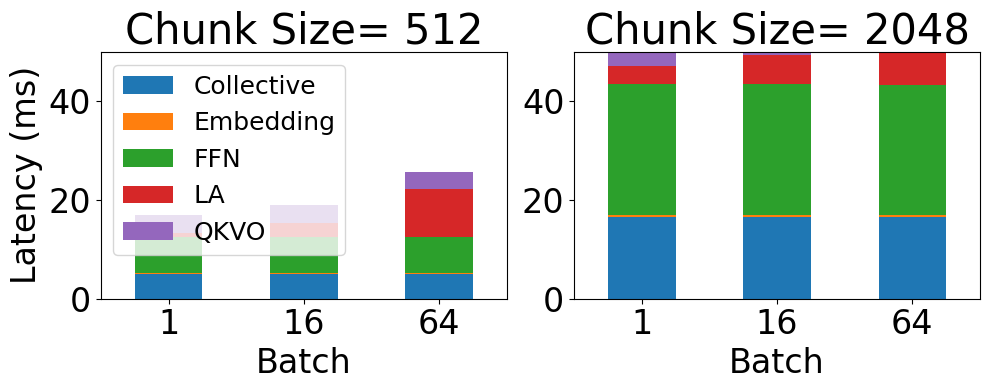

In [7]:
import matplotlib.pyplot as plt

runtime_plot_df['Decode Batch'] = runtime_plot_df['Decode Batch'].astype(str)
runtime_plot_df['Decode Batch'] = pd.Categorical(runtime_plot_df['Decode Batch'], categories=runtime_plot_df['Decode Batch'].unique(), ordered=True)

fig, ax = plt.subplots(figsize=(10, 4), ncols=2)



for i, (key, grp) in enumerate(runtime_plot_df[runtime_plot_df['Batching Type'] == 'Chunked'].groupby(['Chunk Size'])):
    # print(grp.pivot(index=['Decode Batch'], columns='Layer Name', values='Runtime'))
    grp.pivot(index=['Decode Batch'], columns='Layer Name', values='Runtime').plot(kind='bar', stacked=True, ax=ax[i], label=key)

    # ax[i].set_title('Runtime Breakdown by Chunk Size, Input Tokens = {}, Output Tokens = {}, Chunk Size= {}'.format(input_tokens, output_tokens, key[0]))
    ax[i].set_title('Chunk Size= {}'.format(key[0]))
    ax[i].set_ylabel('Latency (ms)')
    ax[i].xaxis.set_tick_params(rotation=0)
    ax[i].tick_params(axis='both', which='major', labelsize=24)

    ax[i].title.set_size(30)
    ax[i].xaxis.label.set_size(24)
    ax[i].yaxis.label.set_size(24)
    # ax[i].xaxis.tick_size = 32
    ax[i].legend(loc='upper left', fontsize=18)
    # ax[i].legend = 2
    ax[i].set_ylim(0, 50)
    if i == 1:
        ax[i].legend().set_visible(False)
        ax[i].set_ylabel('')
    ax[i].set_xlabel('Batch')
plt.savefig('chunked_runtime_breakdown.pdf', format='pdf', dpi=300)
# plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [8]:
system = System(frequency=1000 , flops=4500, off_chip_mem_size=(192*1024), compute_efficiency=1, memory_efficiency=1,
                offchip_mem_bw=8000, bits='int8', external_mem_bw=128, interchip_link_bw=900, interchip_link_latency=0.25, num_nodes=4)
chunked_output = chunked_moddeling(model='deepseek-ai/DeepSeek-V3-Base',
                        prefill_kv_sizes = [(0, 256)],
                        system_name=system, debug=True, bits='int8',
                        decode_kv_sizes = [256, 512] , tensor_parallel=8)

,Layer Name,Op Type,Dimension,Op Intensity,Latency (msec),Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Compute time (msec),Memory time (msec),Communication time (msec),Bound,C/M ratio,Cycles,% of total time,Throughput (Tflops),Compute cycle,Memory cycle,C Effcy,Communication cycle
0,embeddings,GEMM,"[((1, 16160, 256), (7168, 16160), (1, 7168, 256))]",486.897572,0.014180,59307.458560,3.945312,110.468750,1.750000,116.164062,0.006590,0.014180,0.000000,Memory,0.464713,14180.183411,0.116298,4182.418298,6589.717618,14180.183411,1,0.000000
1,Emb_AR,Sync,"(1, 256, 7168)",0.000000,0.011823,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011823,Collective,0.000000,11823.025174,0.096966,0.000000,0.000000,0.000000,1,11823.025174
2,QKV,GEMM,"[((1, 7168, 258), (1008, 7168), (1, 1008, 258))]",399.397596,0.057967,227424.927744,107.583984,420.328125,15.128998,543.041107,0.025269,0.057967,0.000000,Memory,0.435927,57967.190941,0.475415,3923.338772,25269.436416,57967.190941,1,0.000000
3,Logit Pre,Logit,"((1, 16, 256, 56), (1, 1, 256, 56), (1, 16, 256, 256))",90.877971,0.005040,7163.871232,13.343750,0.833984,61.000000,75.177734,0.000796,0.005040,0.000000,Memory,0.157929,5040.142271,0.041336,1421.362899,795.985692,5040.142271,1,0.000000
4,Attend Pre,Attend,"((1, 16, 256, 256), (1, 1, 256, 56), (1, 16, 256, 56))",90.877971,0.005040,7163.871232,61.000000,0.833984,13.343750,75.177734,0.000796,0.005040,0.000000,Memory,0.157929,5040.142271,0.041336,1421.362899,795.985692,5040.142271,1,0.000000
5,Logit Dec,Logit,"((1, 16, 1, 56), (1, 1, 256, 56), (1, 16, 1, 256))",23.735099,0.000118,27.983872,0.052124,0.833984,0.238281,1.124390,0.000003,0.000118,0.000000,Memory,0.026449,117.560228,0.000964,238.038600,3.109319,117.560228,1,0.000000
6,Attend Dec,Attend,"((1, 16, 1, 256), (1, 1, 256, 56), (1, 16, 1, 56))",23.735099,0.000118,27.983872,0.238281,0.833984,0.052124,1.124390,0.000003,0.000118,0.000000,Memory,0.026449,117.560228,0.000964,238.038600,3.109319,117.560228,1,0.000000
7,Logit Dec,Logit,"((1, 16, 1, 56), (1, 1, 512, 56), (1, 16, 1, 512))",24.298305,0.000232,55.967744,0.052124,1.667969,0.476562,2.196655,0.000006,0.000232,0.000000,Memory,0.026771,232.292546,0.001905,240.936461,6.218638,232.292546,1,0.000000
8,Attend Dec,Attend,"((1, 16, 1, 512), (1, 1, 512, 56), (1, 16, 1, 56))",24.298305,0.000232,55.967744,0.476562,1.667969,0.052124,2.196655,0.000006,0.000232,0.000000,Memory,0.026771,232.292546,0.001905,240.936461,6.218638,232.292546,1,0.000000
9,Out Proj,GEMM,"[((1, 896, 258), (7168, 896), (1, 7168, 258))]",389.745838,0.052175,202155.491328,13.447998,373.625000,107.583984,494.656982,0.022462,0.052175,0.000000,Memory,0.430508,52174.925804,0.427910,3874.571707,22461.721259,52174.925804,1,0.000000


,MACs (MFLOP),Total Data (MB),Total Weights (MB),Unused Weights (MB),KV Cache (MB),On-chip Memory Footprint (MB),Latency (msec),Cycles,Attn Latency (msec),Linear Latency (msec),Comm Latency (msec)
0,1945837.43693,83539.87418,83012.23438,0,6.67188,897.05469,12.19297,12192969.82330,0.01078,10.16204,2.02015


In [9]:
system = System(frequency=1000 , flops=4500, off_chip_mem_size=(192*1024), compute_efficiency=1, memory_efficiency=1,
                offchip_mem_bw=8000, bits='int8', external_mem_bw=128, interchip_link_bw=900, interchip_link_latency=0.25, num_nodes=4)
chunked_output = chunked_moddeling(model='deepseek-ai/DeepSeek-V3-Base',
                        prefill_kv_sizes = [], model_profilling=True,
                        system_name=system, debug=True, bits='int8',
                        decode_kv_sizes = [1] , tensor_parallel=1)
display(chunked_output[0])
display(chunked_output[1])


/opt/homebrew/Caskroom/miniconda/base/envs/genz_pip_test/lib/python3.12/site-packages/GenZ/LLM_inference/llm_chunked.py:64: UserWarning:

All params would not fit on chip. System Memory Cap:192.0 GB , Weights : 648.2594299316406 GB, KV Cache:1.2725591659545898e-05 



,Layer Name,Op Type,Dimension,Op Intensity,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB)
0,embeddings,GEMM,"[((1, 129280, 0), (7168, 129280), (1, 7168, 0))]",0.00000,0.00000,0.00000,883.75000,0.00000,883.75000
1,Repeat,Repeat,61,0,0.00000,0.00000,0.00000,0.00000,0.00000
2,QKV,GEMM,"[((1, 7168, 1), (7392, 7168), (1, 7392, 1))]",0.99973,52.98586,0.00684,50.53125,0.00705,50.54514
3,Logit Dec,Logit,"((1, 128, 1, 56), (1, 2, 1, 56), (1, 128, 1, 1))",0.96760,0.00717,0.00684,0.00011,0.00012,0.00706
4,Attend Dec,Attend,"((1, 128, 1, 1), (1, 2, 1, 56), (1, 128, 1, 56))",0.96760,0.00717,0.00012,0.00011,0.00684,0.00706
5,Out Proj,GEMM,"[((1, 7168, 1), (7168, 7168), (1, 7168, 1))]",0.99972,51.38022,0.00684,49.00000,0.00684,49.01367
6,Gate,GEMM,"[((1, 7168, 1), (256, 7168), (1, 256, 1))]",0.99597,1.83501,0.00684,1.75000,0.00024,1.75708
7,up+gate,GEMM,"[((1, 7168, 1), (32768, 7168), (1, 32768, 1))]",0.99983,234.88102,0.00684,224.00000,0.03125,224.03809
8,down,GEMM,"[((1, 16384, 1), (7168, 16384), (1, 7168, 1))]",0.99980,117.44051,0.01562,112.00000,0.00684,112.02246
9,up+gate,GEMM,"[((1, 7168, 0), (1015808, 7168), (1, 1015808, ...",0.00000,0.00000,0.00000,6944.00000,0.00000,6944.00000


,MACs (MFLOP),Total Data (MB),Total Weights (MB),Unused Weights (MB),KV Cache (MB),On-chip Memory Footprint (MB)
0,28897.43360,663824.45453,663817.65625,636259.75000,0.01303,6944.00000


In [10]:
chunked_moddeling(model='gpt-3', 
                        prefill_kv_sizes = [],
                        decode_kv_sizes= [],
                        system_name=system,
                        tensor_parallel=TP, debug=True)

/opt/homebrew/Caskroom/miniconda/base/envs/genz_pip_test/lib/python3.12/site-packages/GenZ/utils/plot_rooflines.py:58: RuntimeWarning:

invalid value encountered in scalar divide

/opt/homebrew/Caskroom/miniconda/base/envs/genz_pip_test/lib/python3.12/site-packages/GenZ/utils/plot_rooflines.py:58: RuntimeWarning:

invalid value encountered in scalar divide

/opt/homebrew/Caskroom/miniconda/base/envs/genz_pip_test/lib/python3.12/site-packages/GenZ/utils/plot_rooflines.py:58: RuntimeWarning:

invalid value encountered in scalar divide

/opt/homebrew/Caskroom/miniconda/base/envs/genz_pip_test/lib/python3.12/site-packages/GenZ/utils/plot_rooflines.py:58: RuntimeWarning:

invalid value encountered in scalar divide

/opt/homebrew/Caskroom/miniconda/base/envs/genz_pip_test/lib/python3.12/site-packages/GenZ/utils/plot_rooflines.py:58: RuntimeWarning:

invalid value encountered in scalar divide

/opt/homebrew/Caskroom/miniconda/base/envs/genz_pip_test/lib/python3.12/site-packages/GenZ/utils/plo

,Layer Name,Op Type,Dimension,Op Intensity,Latency (msec),Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Compute time (msec),Memory time (msec),Communication time (msec),Bound,C/M ratio,Cycles,% of total time,Throughput (Tflops),Compute cycle,Memory cycle,C Effcy,Communication cycle
0,embeddings,GEMM,"[((1, 12568, 0), (12288, 12568), (1, 12288, 0))]",0.000000,0.000000,0.000000,0.000000,294.562500,0.000000,294.562500,0.000000,0.000000,0.000000,Collective,0,0.000000,nan,0.000000,0.000000,0.000000,1,0.000000
1,Emb_AR,Sync,"(1, 0, 12288)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Collective,0,0.000000,nan,0.000000,0.000000,0.000000,1,0.000000
2,QKV,GEMM,"[((1, 12288, 0), (9216, 12288), (1, 9216, 0))]",0.000000,0.000000,0.000000,0.000000,20736.000000,0.000000,20736.000000,0.000000,0.000000,0.000000,Collective,0,0.000000,nan,0.000000,0.000000,0.000000,1,0.000000
3,Out Proj,GEMM,"[((1, 3072, 0), (12288, 3072), (1, 12288, 0))]",0.000000,0.000000,0.000000,0.000000,6912.000000,0.000000,6912.000000,0.000000,0.000000,0.000000,Collective,0,0.000000,nan,0.000000,0.000000,0.000000,1,0.000000
4,MHA AR,Sync,"(1, 0, 12288)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Collective,0,0.000000,nan,0.000000,0.000000,0.000000,1,0.000000
5,up+gate,GEMM,"[((1, 12288, 0), (12288, 12288), (1, 12288, 0))]",0.000000,0.000000,0.000000,0.000000,27648.000000,0.000000,27648.000000,0.000000,0.000000,0.000000,Collective,0,0.000000,nan,0.000000,0.000000,0.000000,1,0.000000
6,down,GEMM,"[((1, 12288, 0), (12288, 12288), (1, 12288, 0))]",0.000000,0.000000,0.000000,0.000000,27648.000000,0.000000,27648.000000,0.000000,0.000000,0.000000,Collective,0,0.000000,nan,0.000000,0.000000,0.000000,1,0.000000
7,FFN AR,Sync,"(1, 0, 12288)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Collective,0,0.000000,nan,0.000000,0.000000,0.000000,1,0.000000
8,classifier,GEMM,"[((1, 12288, 0), (12568, 12288), (1, 12568, 0))]",0.000000,0.000000,0.000000,0.000000,294.562500,0.000000,294.562500,0.000000,0.000000,0.000000,Collective,0,0.000000,nan,0.000000,0.000000,0.000000,1,0.000000
9,classifier_AG,Sync,"(1, 0, 50272)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Collective,0,0.000000,nan,0.000000,0.000000,0.000000,1,0.000000


,MACs (MFLOP),Total Data (MB),Total Weights (MB),Unused Weights (MB),KV Cache (MB),On-chip Memory Footprint (MB),Latency (msec),Cycles,Attn Latency (msec),Linear Latency (msec),Comm Latency (msec)
0,0.00000,83533.12500,83533.12500,83533.12500,0,294.56250,0.00000,0.00000,0,0.00000,0.00000


/opt/homebrew/Caskroom/miniconda/base/envs/genz_pip_test/lib/python3.12/site-packages/GenZ/LLM_inference/llm_chunked.py:98: RuntimeWarning:

invalid value encountered in scalar divide



{'Latency': 0.0,
 'Throughput': nan,
 'Runtime_breakdown': Embedding: 0.0, MHA: 0.0, FFN: 0.0, Collective: 0.0, LA_layers: 0, QKVO_layers: 0.0, FFN_layers: 0.0, Softmax: 0, AR_time: 0.0, A2A_time: 0, Send_Recv_time: 0, Mamba_time: 0,
 'is_offload': False,
 'model_df':        Layer Name    Op Type  \
 0      embeddings       GEMM   
 1          Emb_AR       Sync   
 2          Repeat     Repeat   
 3             QKV       GEMM   
 4        Out Proj       GEMM   
 5          MHA AR       Sync   
 6         up+gate       GEMM   
 7            down       GEMM   
 8          FFN AR       Sync   
 9      End Repeat  EndRepeat   
 10     classifier       GEMM   
 11  classifier_AG       Sync   
 
                                            Dimension       Bound C/M ratio  \
 0   [((1, 12568, 0), (12288, 12568), (1, 12288, 0))]  Collective         0   
 1                                      (1, 0, 12288)  Collective         0   
 2                                                 96  Collectiv